# **MNIST-1D**: Observing deep double descent

This notebook investigates double descent as described in section 8.4 of the ["Understanding Deep Learning"](https://udlbook.github.io/udlbook/) textbook.

The deep double descent phenomenon was [originally described here](https://arxiv.org/abs/1812.11118) and later extended to modern architectures and large datasets in an [OpenAI research project](https://openai.com/blog/deep-double-descent/).

This case study is meant to show the convenience and computational savings of working with the low-dimensional MNIST-1D dataset. You can find more details at https://github.com/greydanus/mnist1d.

In [1]:
import pylab as plt
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Figure style (loading from the web to make running in a Colab easier)
plt.style.use('https://github.com/greydanus/mnist1d/raw/master/notebooks/mpl_style.txt')

In [2]:
# Load MNIST-1D
# (loading from the web to make running in a Colab easier)

from urllib.request import urlopen
import pickle

url = 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'
data = pickle.load(urlopen(url))

print(data['x'].shape)
print(data['x_test'].shape)

(4000, 40)
(1000, 40)


In [3]:
# The experiment works with the default frozen dataset as well,
# but having a larger test set makes the test performance curve smoother.
# So here we generate MNIST-1D with 4000 + 12000 samples.
# Requires installed mnist1d package (pip install mnist1d)

# If running in Google Colab, you can uncomment this line:
# !pip install mnist1d

from mnist1d.data import make_dataset, get_dataset_args

args = get_dataset_args()
args.num_samples = 16_000
args.train_split = 0.25

data = make_dataset(args)

print(data['x'].shape)
print(data['x_test'].shape)

(4000, 40)
(12000, 40)


In [4]:
# Add 15% noise to training labels

import copy
data_with_label_noise = copy.deepcopy(data)

for i in range(len(data['y'])):
    if np.random.random_sample() < 0.15:
        data_with_label_noise['y'][i] = np.random.randint(0, 10)

In [5]:
# Define MLP architecture with one hidden layer

def get_model(n_hidden):
    return nn.Sequential(
        nn.Linear(40, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, 10)
    )

In [6]:
def fit_model(model, data, n_epoch=500):
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    x_train = torch.tensor(data["x"].astype("float32"))
    y_train = torch.tensor(data["y"].transpose().astype("long"))
    x_test = torch.tensor(data["x_test"].astype("float32"))
    y_test = torch.tensor(data["y_test"].astype("long"))

    data_loader = DataLoader(
        TensorDataset(x_train, y_train), batch_size=100, shuffle=True
    )

    # Train the model
    for epoch in range(n_epoch):
        for i, batch in enumerate(data_loader):
            x_batch, y_batch = batch
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_function(pred, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    pred_train = model(x_train)
    pred_test = model(x_test)
    _, predicted_train_class = torch.max(pred_train.data, 1)
    _, predicted_test_class = torch.max(pred_test.data, 1)
    errors_train = 100 * (predicted_train_class != y_train).float().mean()
    errors_test = 100 * (predicted_test_class != y_test).float().mean()
    losses_train = loss_function(pred_train, y_train).item()
    losses_test = loss_function(pred_test, y_test).item()
    print(
        f"Epoch {epoch + 1:5d}, train loss {losses_train:.6f}, train error {errors_train:3.2f}, "
        f"test loss {losses_test:.6f}, test error {errors_test:3.2f}"
    )

    return errors_train, errors_test

In [7]:
%%time

# Without label noise

hidden_variables = np.unique(np.geomspace(2, 300, 20, dtype=int))

errors_train_raw = np.zeros_like(hidden_variables)
errors_test_raw = np.zeros_like(hidden_variables)

for i, size in enumerate(hidden_variables):
    print(f'Training model with {size:3d} hidden variables')
    
    model = get_model(size)
    errors_train, errors_test = fit_model(model, data)
    errors_train_raw[i] = errors_train
    errors_test_raw[i] = errors_test

Training model with   2 hidden variables
Epoch   500, train loss 1.626742, train error 67.15, test loss 1.676046, test error 68.53
Training model with   3 hidden variables
Epoch   500, train loss 1.592728, train error 63.88, test loss 1.663565, test error 66.83
Training model with   4 hidden variables
Epoch   500, train loss 1.356913, train error 54.78, test loss 1.447518, test error 58.27
Training model with   5 hidden variables
Epoch   500, train loss 1.435448, train error 57.23, test loss 1.537323, test error 61.37
Training model with   7 hidden variables
Epoch   500, train loss 1.199873, train error 48.03, test loss 1.375124, test error 54.20
Training model with   9 hidden variables
Epoch   500, train loss 1.040277, train error 41.28, test loss 1.307993, test error 49.33
Training model with  12 hidden variables
Epoch   500, train loss 0.979797, train error 38.40, test loss 1.356770, test error 50.08
Training model with  16 hidden variables
Epoch   500, train loss 0.733982, train er

In [8]:
%%time

# With label noise

hidden_variables = np.unique(np.geomspace(2, 300, 20, dtype=int))

errors_train_noisy = np.zeros_like(hidden_variables)
errors_test_noisy = np.zeros_like(hidden_variables)

for i, size in enumerate(hidden_variables):
    print(f'Training model with {size:3d} hidden variables')
        
    model = get_model(size)
    errors_train, errors_test = fit_model(model, data_with_label_noise)
    errors_train_noisy[i] = errors_train
    errors_test_noisy[i] = errors_test

Training model with   2 hidden variables
Epoch   500, train loss 1.918945, train error 71.68, test loss 1.757478, test error 69.59
Training model with   3 hidden variables
Epoch   500, train loss 1.833644, train error 68.65, test loss 1.714114, test error 67.50
Training model with   4 hidden variables
Epoch   500, train loss 1.767615, train error 62.75, test loss 1.653679, test error 62.55
Training model with   5 hidden variables
Epoch   500, train loss 1.623392, train error 57.95, test loss 1.466705, test error 57.45
Training model with   7 hidden variables
Epoch   500, train loss 1.545471, train error 54.45, test loss 1.419071, test error 54.80
Training model with   9 hidden variables
Epoch   500, train loss 1.429673, train error 47.45, test loss 1.344300, test error 48.97
Training model with  12 hidden variables
Epoch   500, train loss 1.373848, train error 46.47, test loss 1.371256, test error 50.28
Training model with  16 hidden variables
Epoch   500, train loss 1.204145, train er

In [9]:
# Define CNN architecture

def get_model_cnn(channels):
    return nn.Sequential(
        nn.Conv1d(1, channels, 5, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv1d(channels, channels, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv1d(channels, channels, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(channels * 5, 10),
    )

In [10]:
%%time

# With label noise
# Need to reshape the data arrays to make them compatible with the conv1d layers

ddata = data_with_label_noise.copy()
ddata['x'] = data['x'][:, np.newaxis, :]
ddata['x_test'] = data['x_test'][:, np.newaxis, :]

channels = np.concatenate((np.arange(2, 30, 2), np.arange(30, 101, 5)))

errors_train_cnn = np.zeros_like(channels)
errors_test_cnn = np.zeros_like(channels)

for i, size in enumerate(channels):
    print(f'Training model with {size:3d} channels')
    
    model = get_model_cnn(size)
    errors_train, errors_test = fit_model(model, ddata, n_epoch=500)
    errors_train_cnn[i] = errors_train
    errors_test_cnn[i] = errors_test

Training model with   2 channels
Epoch   500, train loss 1.842762, train error 63.90, test loss 1.634232, test error 61.20
Training model with   4 channels
Epoch   500, train loss 1.353123, train error 40.40, test loss 1.020193, test error 35.78
Training model with   6 channels
Epoch   500, train loss 1.090348, train error 29.15, test loss 0.787633, test error 23.87
Training model with   8 channels
Epoch   500, train loss 0.930178, train error 24.90, test loss 0.691253, test error 21.95
Training model with  10 channels
Epoch   500, train loss 0.737799, train error 19.55, test loss 0.623556, test error 19.64
Training model with  12 channels
Epoch   500, train loss 0.697752, train error 19.82, test loss 0.756008, test error 23.70
Training model with  14 channels
Epoch   500, train loss 0.589387, train error 17.98, test loss 0.951923, test error 27.74
Training model with  16 channels
Epoch   500, train loss 0.413599, train error 12.70, test loss 0.985720, test error 27.29
Training model w

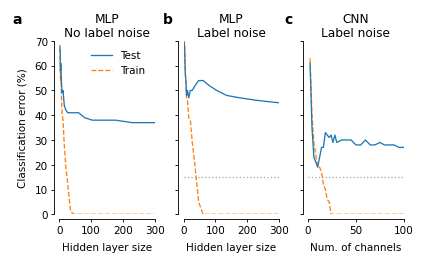

In [12]:
fig, axs = plt.subplots(ncols=3, figsize=(3.25, 2), dpi=125)

axs[0].plot(hidden_variables, errors_test_raw, '-', label='Test')
axs[0].plot(hidden_variables, errors_train_raw, '--', label='Train', zorder=0)

axs[0].set_ylim(0, 70)
axs[0].set_xlim(0, 300)
axs[1].set_xticks([0, 100, 200, 300])
axs[0].set_xlabel('Hidden layer size')
axs[0].set_ylabel('Classification error (%)')
axs[0].legend()
axs[0].set_title('MLP\nNo label noise')

axs[0].spines.left.set_position(('outward', 3))
axs[0].spines.bottom.set_position(('outward', 3))

axs[1].plot(hidden_variables, errors_test_noisy, '-', label='Test')
axs[1].plot(hidden_variables, errors_train_noisy, '--', label='Train', zorder=0)

axs[1].set_ylim(0, 70)
axs[1].set_xlim(0, 300)
axs[1].set_xticks([0, 100, 200, 300])
axs[1].set_xlabel('Hidden layer size')
axs[1].set_yticklabels([])
axs[1].set_title('MLP\nLabel noise')
axs[1].plot([0, 300], [15, 15], ':', zorder=-1, color='#aaaaaa')

axs[1].spines.left.set_position(('outward', 3))
axs[1].spines.bottom.set_position(('outward', 3))

axs[2].plot(channels, errors_test_cnn, '-', label='Test')
axs[2].plot(channels, errors_train_cnn, '--', label='Train', zorder=0)

axs[2].set_ylim(0, 70)
axs[2].set_xlim(0, 100)
axs[2].set_yticklabels([])
axs[2].set_xlabel('Num. of channels')
axs[2].set_title('CNN\nLabel noise')
axs[2].plot([0, 100], [15, 15], ':', zorder=-1, color='#aaaaaa')

axs[2].spines.left.set_position(('outward', 3))
axs[2].spines.bottom.set_position(('outward', 3))

fig.text(  0, .94, 'a', fontsize=8, weight='bold')
fig.text(.37, .94, 'b', fontsize=8, weight='bold')
fig.text(.67, .94, 'c', fontsize=8, weight='bold')

fig.savefig('figures/double-descent.png', dpi=300)
fig.savefig('figures/double-descent.pdf')